In [49]:
import pandas as pd 
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

🎯 Goal
Develop a model that predicts gold recovery at two key process stages:

1) Rougher concentrate recovery — rougher.output.recovery

2) Final concentrate recovery — final.output.recovery

You’ll use industrial process data to build models that estimate how efficiently gold is extracted at these two points.

In [50]:
gold_recovery_full = pd.read_csv('gold_recovery_full.csv')
gold_recovery_test = pd.read_csv('gold_recovery_test.csv')
gold_recovery_train = pd.read_csv('gold_recovery_train.csv')

In [51]:
display(gold_recovery_test.head(3))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

df = gold_recovery_train.copy()

cols_needed = [
    'rougher.output.recovery',
    'rougher.output.concentrate_au',
    'rougher.input.feed_au',
    'rougher.output.tail_au'
]

df = df[cols_needed].dropna()

C = df['rougher.output.concentrate_au']
F = df['rougher.input.feed_au']
T = df['rougher.output.tail_au']

recovery_calc = (C * (F - T)) / (F * (C - T)) * 100

actual_recovery = df['rougher.output.recovery']
mae = mean_absolute_error(actual_recovery, recovery_calc)

print(f"MAE between actual and calculated rougher recovery: {mae:.6f}")


MAE between actual and calculated rougher recovery: 0.000000


In [53]:
train_features = set(gold_recovery_train.columns)
test_features = set(gold_recovery_test.columns)

missing_features = sorted(list(train_features - test_features))
print(f"Missing columns in test set ({len(missing_features)}):\n")
for feature in missing_features:
    print(f"- {feature} ({gold_recovery_train[feature].dtype})")


Missing columns in test set (34):

- final.output.concentrate_ag (float64)
- final.output.concentrate_au (float64)
- final.output.concentrate_pb (float64)
- final.output.concentrate_sol (float64)
- final.output.recovery (float64)
- final.output.tail_ag (float64)
- final.output.tail_au (float64)
- final.output.tail_pb (float64)
- final.output.tail_sol (float64)
- primary_cleaner.output.concentrate_ag (float64)
- primary_cleaner.output.concentrate_au (float64)
- primary_cleaner.output.concentrate_pb (float64)
- primary_cleaner.output.concentrate_sol (float64)
- primary_cleaner.output.tail_ag (float64)
- primary_cleaner.output.tail_au (float64)
- primary_cleaner.output.tail_pb (float64)
- primary_cleaner.output.tail_sol (float64)
- rougher.calculation.au_pb_ratio (float64)
- rougher.calculation.floatbank10_sulfate_to_au_feed (float64)
- rougher.calculation.floatbank11_sulfate_to_au_feed (float64)
- rougher.calculation.sulfate_to_au_concentrate (float64)
- rougher.output.concentrate_ag (fl

### 1.4

In [54]:
for df in [gold_recovery_train, gold_recovery_test, gold_recovery_full]:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

target_columns = ['rougher.output.recovery', 'final.output.recovery']
shared_feature_columns = gold_recovery_train.columns.intersection(gold_recovery_test.columns)

train_features = gold_recovery_train[shared_feature_columns].copy()
train_target = gold_recovery_train[target_columns].copy()
test_features = gold_recovery_test[shared_feature_columns].copy()

train_features = train_features.ffill()
test_features = test_features.ffill()
train_target = train_target.ffill()

train_features.sort_index(inplace=True)
test_features.sort_index(inplace=True)
train_target.sort_index(inplace=True)

print("Finished preprocessing")

Finished preprocessing


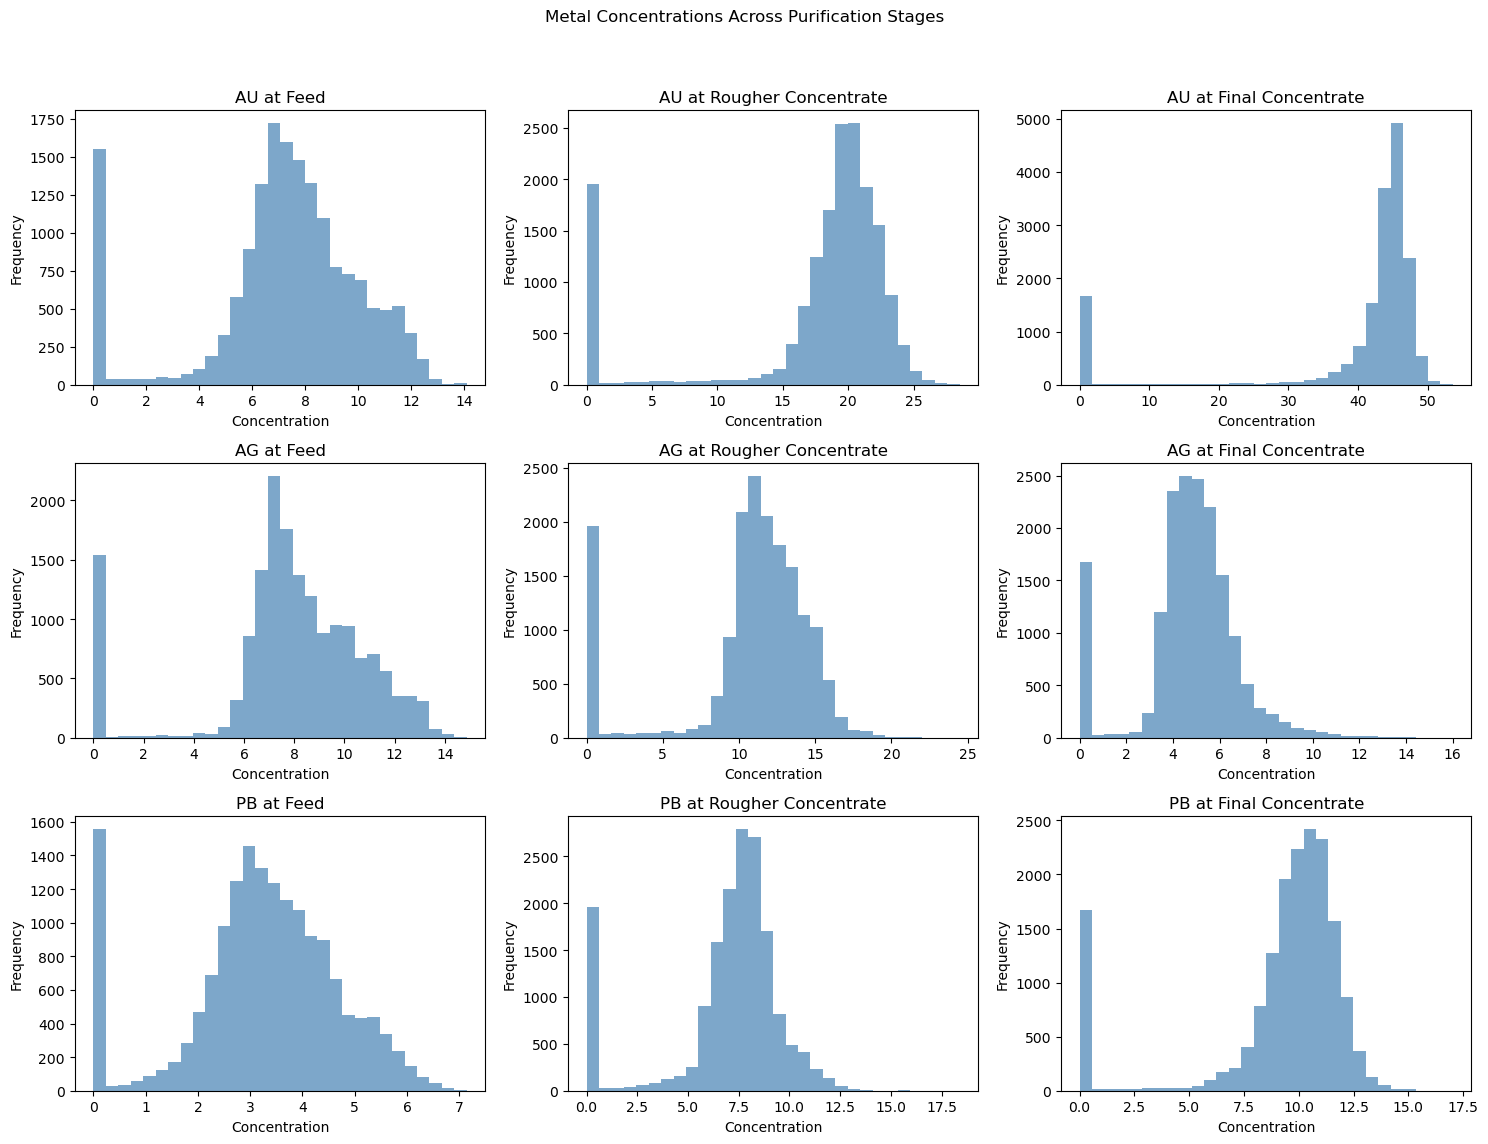

In [55]:

import matplotlib.pyplot as plt

metals = ['au', 'ag', 'pb']

stages = {
    'feed': ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb'],
    'rougher_concentrate': ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb'],
    'final_concentrate': ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Metal Concentrations Across Purification Stages')

for i, metal in enumerate(metals):
    for j, (stage, cols) in enumerate(stages.items()):
        col = cols[i]
        if col in gold_recovery_train.columns:
            axes[i, j].hist(gold_recovery_train[col].dropna(), bins=30, color='steelblue', alpha=0.7)
            axes[i, j].set_title(f'{metal.upper()} at {stage.replace("_", " ").title()}')
            axes[i, j].set_xlabel('Concentration')
            axes[i, j].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### 2.2

C:\Users\duriv\AppData\Local\Temp\ipykernel_12112\3141503588.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gold_recovery_train['rougher.input.feed_size'], label='Train', shade=True)
e:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\duriv\AppData\Local\Temp\ipykernel_12112\3141503588.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gold_recovery_test['rougher.input.feed_size'], label='Test', shade=True)
e:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

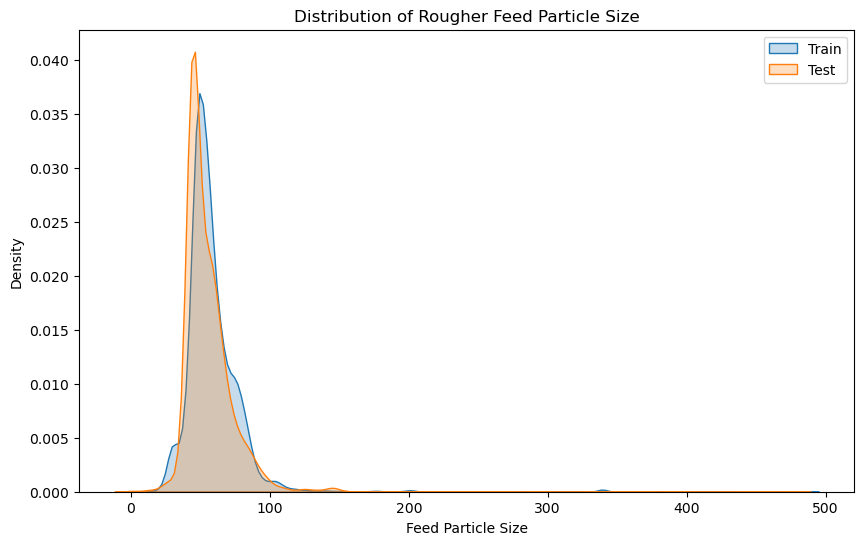

In [56]:
import seaborn as sns

plt.figure(figsize=(10,6))

sns.kdeplot(gold_recovery_train['rougher.input.feed_size'], label='Train', shade=True)
sns.kdeplot(gold_recovery_test['rougher.input.feed_size'], label='Test', shade=True)

plt.title('Distribution of Rougher Feed Particle Size')
plt.xlabel('Feed Particle Size')
plt.ylabel('Density')
plt.legend()
plt.show()


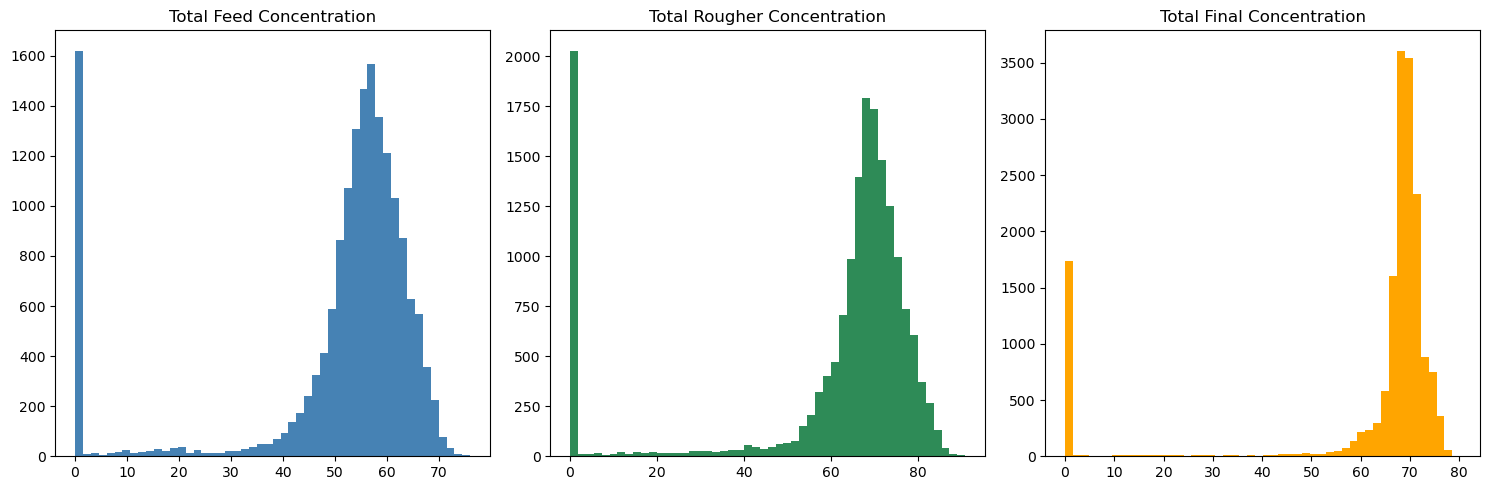

In [57]:
# Define columns to sum at each stage
feed_cols = [col for col in gold_recovery_train.columns if 'feed_' in col and ('_au' in col or '_ag' in col or '_pb' in col or '_sol' in col)]
rougher_cols = [col for col in gold_recovery_train.columns if 'rougher.output.concentrate' in col]
final_cols = [col for col in gold_recovery_train.columns if 'final.output.concentrate' in col]

# Sum concentrations for each row
gold_recovery_train['total_feed_concentration'] = gold_recovery_train[feed_cols].sum(axis=1)
gold_recovery_train['total_rougher_concentration'] = gold_recovery_train[rougher_cols].sum(axis=1)
gold_recovery_train['total_final_concentration'] = gold_recovery_train[final_cols].sum(axis=1)

# Visualize distributions to spot anomalies
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(gold_recovery_train['total_feed_concentration'], bins=50, color='steelblue')
plt.title('Total Feed Concentration')

plt.subplot(1, 3, 2)
plt.hist(gold_recovery_train['total_rougher_concentration'], bins=50, color='seagreen')
plt.title('Total Rougher Concentration')

plt.subplot(1, 3, 3)
plt.hist(gold_recovery_train['total_final_concentration'], bins=50, color='orange')
plt.title('Total Final Concentration')

plt.tight_layout()
plt.show()


In [58]:
# Threshold to define anomaly (zero or near-zero sums)
threshold = 0.1

# Find indices where total concentrations are below threshold
anomaly_indices_train = gold_recovery_train[
    (gold_recovery_train['total_feed_concentration'] < threshold) |
    (gold_recovery_train['total_rougher_concentration'] < threshold) |
    (gold_recovery_train['total_final_concentration'] < threshold)
].index

# Drop those anomalies from train dataset
gold_recovery_train_cleaned = gold_recovery_train.drop(index=anomaly_indices_train)

# Do the same for test dataset (calculate totals first)
feed_cols = [col for col in gold_recovery_test.columns if 'feed_' in col and ('_au' in col or '_ag' in col or '_pb' in col or '_sol' in col)]
rougher_cols = [col for col in gold_recovery_test.columns if 'rougher.output.concentrate' in col]
final_cols = [col for col in gold_recovery_test.columns if 'final.output.concentrate' in col]

gold_recovery_test['total_feed_concentration'] = gold_recovery_test[feed_cols].sum(axis=1)
gold_recovery_test['total_rougher_concentration'] = gold_recovery_test[rougher_cols].sum(axis=1)
gold_recovery_test['total_final_concentration'] = gold_recovery_test[final_cols].sum(axis=1)

anomaly_indices_test = gold_recovery_test[
    (gold_recovery_test['total_feed_concentration'] < threshold) |
    (gold_recovery_test['total_rougher_concentration'] < threshold) |
    (gold_recovery_test['total_final_concentration'] < threshold)
].index

gold_recovery_test_cleaned = gold_recovery_test.drop(index=anomaly_indices_test)


### 3.0

In [59]:
import numpy as np

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    smape_val = np.mean(diff / denominator) * 100
    return smape_val

def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    final_score = 0.25 * smape_rougher + 0.75 * smape_final
    return final_score


### Machine Learning Time 

In [60]:
print("Test set columns:", gold_recovery_test_cleaned.columns.tolist())
print("Shared features:", shared_feature_columns)
missing_cols = set(shared_feature_columns) - set(gold_recovery_test_cleaned.columns)
print("Missing columns in test set:", missing_cols)


Test set columns: ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air', 'primary_cleaner.state.floatbank8_a_level', 'primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_b_level', 'primary_cleaner.state.floatbank8_c_air', 'primary_cleaner.state.floatbank8_c_level', 'primary_cleaner.state.floatbank8_d_air', 'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.

In [61]:
print("Raw test dataframe shape:", gold_recovery_test_cleaned.shape)
print("Sample of raw test data:")
print(gold_recovery_test_cleaned.head())
print("Number of nulls per column:")
print(gold_recovery_test_cleaned.isnull().sum())


Raw test dataframe shape: (0, 55)
Sample of raw test data:
Empty DataFrame
Columns: [primary_cleaner.input.sulfate, primary_cleaner.input.depressant, primary_cleaner.input.feed_size, primary_cleaner.input.xanthate, primary_cleaner.state.floatbank8_a_air, primary_cleaner.state.floatbank8_a_level, primary_cleaner.state.floatbank8_b_air, primary_cleaner.state.floatbank8_b_level, primary_cleaner.state.floatbank8_c_air, primary_cleaner.state.floatbank8_c_level, primary_cleaner.state.floatbank8_d_air, primary_cleaner.state.floatbank8_d_level, rougher.input.feed_ag, rougher.input.feed_pb, rougher.input.feed_rate, rougher.input.feed_size, rougher.input.feed_sol, rougher.input.feed_au, rougher.input.floatbank10_sulfate, rougher.input.floatbank10_xanthate, rougher.input.floatbank11_sulfate, rougher.input.floatbank11_xanthate, rougher.state.floatbank10_a_air, rougher.state.floatbank10_a_level, rougher.state.floatbank10_b_air, rougher.state.floatbank10_b_level, rougher.state.floatbank10_c_air, rou

In [62]:
test_features_clean = gold_recovery_test_cleaned[shared_feature_columns].ffill().bfill()

if test_features_clean.shape[0] == 0:
    print("Warning: Test dataset is empty. No predictions made.")
    test_predictions = None
else:
    test_predictions = best_model.predict(test_features_clean)
    print("Predictions on test set generated.")

In [63]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

# Assume features and target are already defined properly from your train set
# features = gold_recovery_train[feature_columns].ffill().bfill()
# target = gold_recovery_train[target_columns].ffill().bfill()

# Split training data into train + validation sets (80/20)
features_train, features_val, target_train, target_val = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# sklearn-compatible SMAPE scorer for cross_val_score (negated)
def sklearn_smape(y_true, y_pred):
    smape_rougher = smape(y_true[:, 0], y_pred[:, 0])
    smape_final = smape(y_true[:, 1], y_pred[:, 1])
    final_score = 0.25 * smape_rougher + 0.75 * smape_final
    return -final_score  # negative because sklearn maximizes score

smape_scorer = make_scorer(sklearn_smape, greater_is_better=True)

# Define models to test with lighter RandomForest params for speed
models = {
    'Ridge': MultiOutputRegressor(make_pipeline(StandardScaler(), Ridge(alpha=1.0))),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(n_estimators=30, max_depth=15, random_state=42, n_jobs=-1)),
    'SVR': MultiOutputRegressor(make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1)))
}

# Cross-validation on train split (optional, can skip if slow)
print("Cross-validation scores:")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(model, features_train, target_train, cv=kf, scoring=smape_scorer, n_jobs=-1)
    print(f"{name}: Mean CV SMAPE = {-scores.mean():.4f}")

# Train each model on train split and evaluate on validation set
val_scores = {}
for name, model in models.items():
    model.fit(features_train, target_train)
    val_pred = model.predict(features_val)
    score = final_smape(
        target_val['rougher.output.recovery'].values,
        val_pred[:, 0],
        target_val['final.output.recovery'].values,
        val_pred[:, 1]
    )
    val_scores[name] = score
    print(f"{name} Validation final SMAPE: {score:.4f}")

# Select best model based on validation SMAPE (lowest is best)
best_model_name = min(val_scores, key=val_scores.get)
best_model = models[best_model_name]
print(f"\nBest model selected: {best_model_name}")

# Train best model on full training data
best_model.fit(features, target)

# Prepare test features - fill missing and select shared columns safely
if 'shared_feature_columns' not in globals():
    # Fallback: use feature columns from train if shared_feature_columns not defined
    shared_feature_columns = features.columns.tolist()

# Ensure test dataframe is loaded and cleaned already as gold_recovery_test_cleaned
test_features_clean = gold_recovery_test_cleaned[shared_feature_columns].ffill().bfill()

# Predict on test set
test_predictions = best_model.predict(test_features_clean)

print("Predictions on test set generated. Since targets are missing in test, evaluation is not possible.")


Cross-validation scores:
Ridge: Mean CV SMAPE = nan
RandomForest: Mean CV SMAPE = nan
SVR: Mean CV SMAPE = nan
Ridge Validation final SMAPE: 8.0851
RandomForest Validation final SMAPE: 5.9690
SVR Validation final SMAPE: 6.5974

Best model selected: RandomForest


ValueError: Found array with 0 sample(s) (shape=(0, 52)) while a minimum of 1 is required by RandomForestRegressor.

In [39]:
print(target_columns)
print([col for col in target_columns if col in gold_recovery_test.columns])


['rougher.output.recovery', 'final.output.recovery']
[]
